In [5]:
import cv2
import mediapipe as mp
import numpy as np
import os
import csv
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [7]:
from tensorflow.keras.models import Sequential #allows to build a sequential neural network
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

In [8]:
from IPython.display import clear_output

In [9]:
from sklearn.metrics import confusion_matrix

In [5]:
np.random.seed(seed=42)

In [6]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        
#fonction qui permet de dessiner les graphes

In [12]:
final = np.load('dictionnairefinal.npy', allow_pickle=True).item()

In [13]:
classes = np.array(['A001','A004','A006','A007','A008','A009','A010','A022',
           'A023','A024','A026','A027','A031','A032','A034','A038',
           'A040','A041','A043','A044','A045','A046','A047'])

In [14]:
vidlist = []
labels = []
index = 0
i =0 

for key in final.keys():
    while(index < len(final[key])):
        vidlist.append(final[key][index])
        labels.append(i)
        index += 1
    index = 0
    i +=1


In [15]:
x = np.array(vidlist, dtype=object)
x = np.array(x).astype("float32")

In [16]:
x.shape

(48394, 30, 33, 4)

In [17]:
x = x[:,:,:,:-1]
#pour effacer visibility

In [18]:
x_ = x.reshape(48394,30,33*3)

In [19]:
x_.shape

(48394, 30, 99)

In [20]:
y = np.array(labels)
y = to_categorical(labels).astype(int)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_,y,test_size=0.05)

In [23]:
x_test.shape

(2420, 30, 99)

In [22]:
log_dir = os.path.join('Logsnew')
tb_callback = TensorBoard(log_dir=log_dir)

In [71]:
actual_labels = y_test
actual_labels = actual_labels.argmax(axis=1)

## Model0

In [52]:
model_checkpoint_callback0 = tf.keras.callbacks.ModelCheckpoint(
    filepath='reseau0.h5',
    save_weights_only=True,
    monitor='categorical_accuracy',
    mode='max',
    save_best_only=True)

In [98]:
model0 = Sequential()
model0.add(LSTM(64,return_sequences=True, activation='relu',input_shape=(30,99)))
model0.add(LSTM(128,return_sequences=True, activation='relu'))
model0.add(LSTM(64,return_sequences=False, activation='relu')) #3 couches of LSTM
model0.add(Dense(64, activation='relu'))
model0.add(Dense(32, activation='relu'))
model0.add(Dense(classes.shape[0], activation='softmax'))
#dense layers = fully connected layers

In [99]:
model0.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

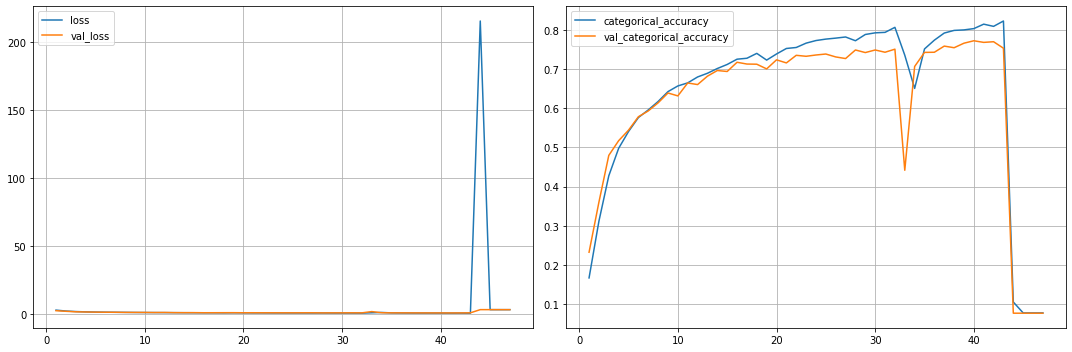

90/90 [==============================] - 19s 209ms/step - loss: 3.1105 - categorical_accuracy: 0.0771 - val_loss: 3.1111 - val_categorical_accuracy: 0.0764
Epoch 48/200
 2/90 [..............................] - ETA: 17s - loss: 3.1079 - categorical_accuracy: 0.0762

KeyboardInterrupt: 

In [100]:
model0.fit(x_train, y_train, epochs=200,batch_size=512,validation_data=(x_test,y_test), callbacks=[tb_callback, model_checkpoint_callback0, PlotLearning()])

In [93]:
del model0

In [105]:
model0.load_weights('reseau0.h5')

In [106]:
model0.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 30, 64)            41984     
                                                                 
 lstm_43 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_44 (LSTM)              (None, 64)                49408     
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 23)                759       
                                                                 
Total params: 197,207
Trainable params: 197,207
Non-t

In [74]:
loss,acc = model0.evaluate(x_test,y_test,verbose=2)

76/76 - 3s - loss: 0.8525 - categorical_accuracy: 0.7901 - 3s/epoch - 37ms/step


In [75]:
predicted_labels0 = model0.predict(x_test)
predicted_labels0 = predicted_labels0.argmax(axis=1)

In [76]:
cm0 = confusion_matrix(actual_labels,predicted_labels0)

Text(33.0, 0.5, 'Actual classes')

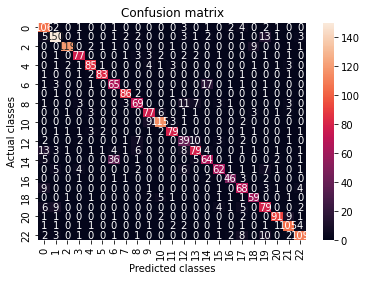

In [77]:
ax = sns.heatmap(cm0,annot=True,fmt='g')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')

## Model1

In [55]:
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='reseau1.h5',
    save_weights_only=True,
    monitor='categorical_accuracy',
    mode='max',
    save_best_only=True)

In [102]:
model1 = Sequential()
model1.add(LSTM(32,return_sequences=True, activation='relu',input_shape=(30,99)))
model1.add(LSTM(64,return_sequences=True, activation='relu'))
model1.add(LSTM(32,return_sequences=False, activation='relu')) #3 couches of LSTM
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(classes.shape[0], activation='softmax'))

In [57]:
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

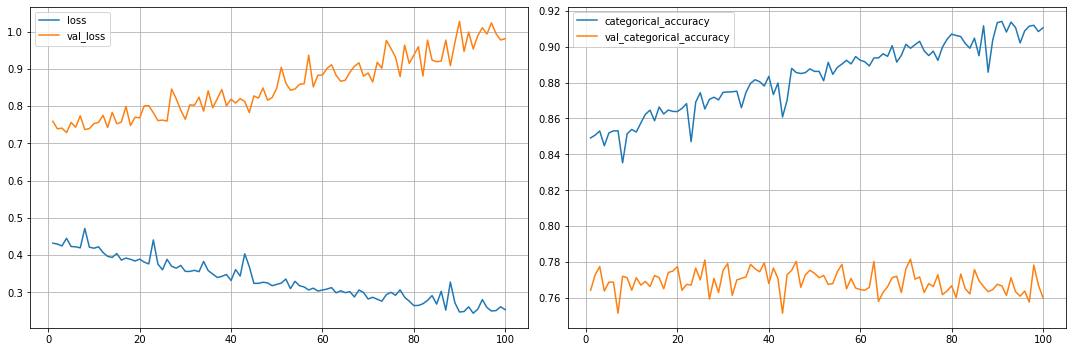

90/90 [==============================] - 16s 180ms/step - loss: 0.2530 - categorical_accuracy: 0.9106 - val_loss: 0.9810 - val_categorical_accuracy: 0.7599


In [69]:
model1.fit(x_train, y_train, epochs=100,batch_size=512,validation_data=(x_test,y_test), callbacks=[tb_callback, model_checkpoint_callback1, PlotLearning()])

In [103]:
model1.load_weights('reseau1.h5')

In [104]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 30, 32)            16896     
                                                                 
 lstm_46 (LSTM)              (None, 30, 64)            24832     
                                                                 
 lstm_47 (LSTM)              (None, 32)                12416     
                                                                 
 dense_35 (Dense)            (None, 32)                1056      
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 23)                391       
                                                                 
Total params: 56,119
Trainable params: 56,119
Non-tra

In [94]:
del model1

In [79]:
loss,acc = model1.evaluate(x_test,y_test,verbose=2)

76/76 - 3s - loss: 0.9468 - categorical_accuracy: 0.7665 - 3s/epoch - 40ms/step


In [80]:
predicted_labels1 = model1.predict(x_test)
predicted_labels1 = predicted_labels1.argmax(axis=1)

In [81]:
cm1 = confusion_matrix(actual_labels,predicted_labels1)

Text(33.0, 0.5, 'Actual classes')

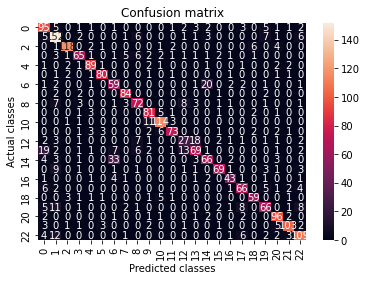

In [82]:
ax = sns.heatmap(cm1,annot=True,fmt='g')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')

## Model2

In [58]:
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='reseau2.h5',
    save_weights_only=True,
    monitor='categorical_accuracy',
    mode='max',
    save_best_only=True)

In [108]:
model2 = Sequential()
model2.add(LSTM(32,return_sequences=True, activation='relu',input_shape=(30,99)))
model2.add(LSTM(64,return_sequences=True, activation='relu'))
model2.add(LSTM(128,return_sequences=True, activation='relu'))
model2.add(LSTM(256,return_sequences=True, activation='relu'))
model2.add(LSTM(128,return_sequences=True, activation='relu'))
model2.add(LSTM(64,return_sequences=True, activation='relu'))
model2.add(LSTM(32,return_sequences=False, activation='relu')) #3 couches of LSTM
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(classes.shape[0], activation='softmax'))

In [60]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

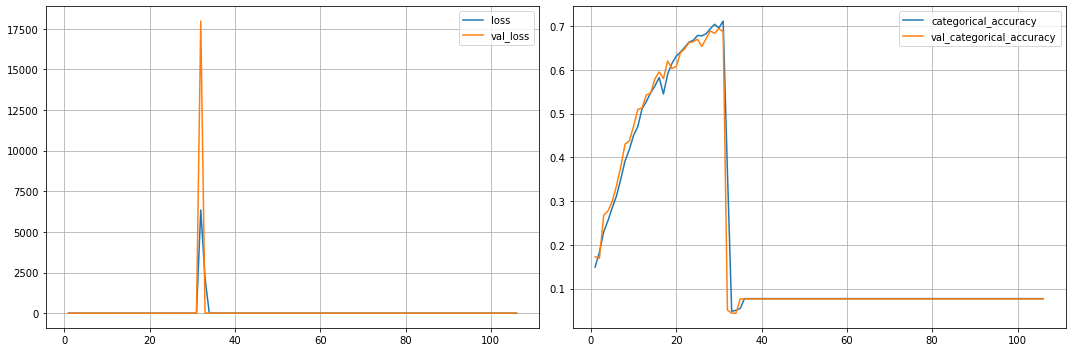

90/90 [==============================] - 43s 473ms/step - loss: 3.1056 - categorical_accuracy: 0.0771 - val_loss: 3.1087 - val_categorical_accuracy: 0.0764
Epoch 107/200
21/90 [======>.......................] - ETA: 34s - loss: 3.1061 - categorical_accuracy: 0.0773

KeyboardInterrupt: 

In [68]:
model2.fit(x_train, y_train, epochs=200,batch_size=512,validation_data=(x_test,y_test), callbacks=[tb_callback, model_checkpoint_callback2, PlotLearning()])

In [109]:
model2.load_weights('reseau2.h5')

In [110]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 30, 32)            16896     
                                                                 
 lstm_49 (LSTM)              (None, 30, 64)            24832     
                                                                 
 lstm_50 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_51 (LSTM)              (None, 30, 256)           394240    
                                                                 
 lstm_52 (LSTM)              (None, 30, 128)           197120    
                                                                 
 lstm_53 (LSTM)              (None, 30, 64)            49408     
                                                                 
 lstm_54 (LSTM)              (None, 32)              

In [95]:
del model2

In [84]:
loss,acc = model2.evaluate(x_test,y_test,verbose=2)

76/76 - 7s - loss: 0.9107 - categorical_accuracy: 0.6876 - 7s/epoch - 88ms/step


In [85]:
predicted_values2 = model2.predict(x_test)
predicted_values2 = predicted_values2.argmax(axis=1)

In [86]:
cm2 = confusion_matrix(actual_labels,predicted_values2)

Text(33.0, 0.5, 'Actual classes')

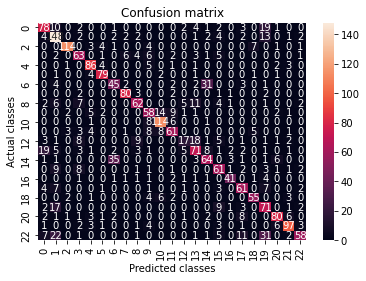

In [87]:
ax = sns.heatmap(cm2,annot=True,fmt='g')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')

## Model3

In [61]:
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath='reseau3.h5',
    save_weights_only=True,
    monitor='categorical_accuracy',
    mode='max',
    save_best_only=True)

In [112]:
model3 = Sequential()
model3.add(LSTM(64,return_sequences=True, activation='relu',input_shape=(30,99)))
model3.add(LSTM(128,return_sequences=True, activation='relu'))
model3.add(LSTM(256,return_sequences=True, activation='relu'))
model3.add(LSTM(128,return_sequences=True, activation='relu'))
model3.add(LSTM(64,return_sequences=False, activation='relu')) #3 couches of LSTM
model3.add(Dense(128, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(classes.shape[0], activation='softmax'))
#dense layers = fully connected layers

In [63]:
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [96]:
del model3


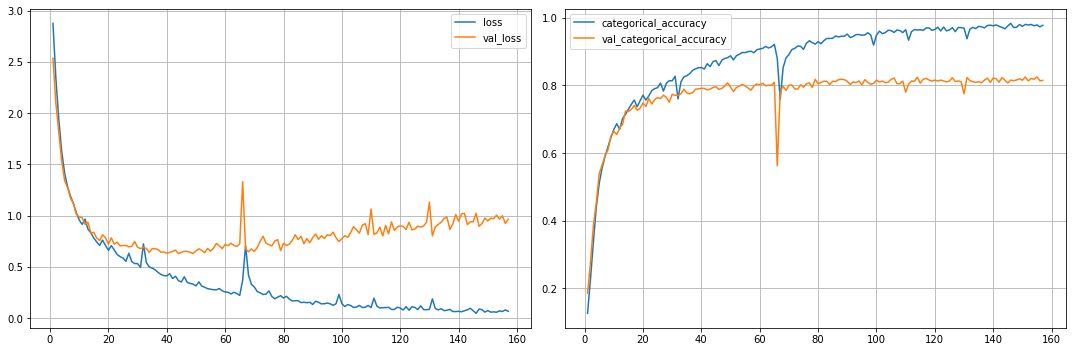

90/90 [==============================] - 29s 325ms/step - loss: 0.0661 - categorical_accuracy: 0.9778 - val_loss: 0.9654 - val_categorical_accuracy: 0.8149
Epoch 158/200
38/90 [===========>..................] - ETA: 17s - loss: 0.0484 - categorical_accuracy: 0.9840

KeyboardInterrupt: 

In [70]:
model3.fit(x_train, y_train, epochs=200,batch_size=512,validation_data=(x_test,y_test), callbacks=[tb_callback, model_checkpoint_callback3, PlotLearning()])

In [113]:
model3.load_weights('reseau3.h5')

In [114]:
model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 30, 64)            41984     
                                                                 
 lstm_56 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_57 (LSTM)              (None, 30, 256)           394240    
                                                                 
 lstm_58 (LSTM)              (None, 30, 128)           197120    
                                                                 
 lstm_59 (LSTM)              (None, 64)                49408     
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dense_42 (Dense)            (None, 256)             

In [89]:
loss,acc = model3.evaluate(x_test,y_test,verbose=2)

76/76 - 5s - loss: 1.0228 - categorical_accuracy: 0.8157 - 5s/epoch - 61ms/step


In [90]:
predicted_values3 = model3.predict(x_test)
predicted_values3 = predicted_values3.argmax(axis=1)

In [91]:
cm3 = confusion_matrix(actual_labels,predicted_values3)

Text(33.0, 0.5, 'Actual classes')

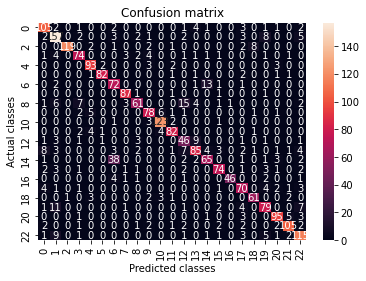

In [92]:
ax = sns.heatmap(cm3,annot=True,fmt='g')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted classes')
ax.set_ylabel('Actual classes')